<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Rede-Neurais-LSTM--Doencas-Pulmonares/blob/main/RedesRecorrentesDoencaPulmonares_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM e GRU


## Parte 1 - Pré-processamento de Dados

#### Importar as bibliotecas

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD
np.random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/Trabalho Redes Neurais/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importar a base de dados

In [ ]:
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

#### Gráfico da série temporal

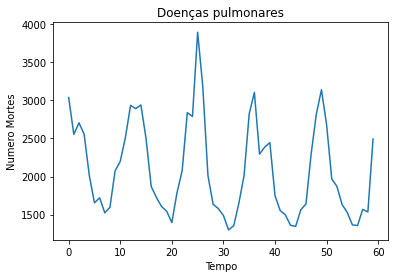

In [ ]:
plt.plot(training_set)
plt.xlabel("Tempo")
plt.ylabel("Numero Mortes")
plt.title("Doenças pulmonares")
plt.show()

#### Normalização

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Parte 2 - LSTM

#### Criar a estrutura de dados com janela 15 e output 1

In [ ]:
window = 15
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#### Reshaping

In [ ]:
X_train.shape

(45, 15)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(45, 15, 1)

#### Variáveis

In [ ]:
num_epoch = 500
learning_rate = 0.01
batch_size = 32

#### Callbacks

In [ ]:
#es = EarlyStopping(monitor="val_loss", min_delta = 0.00001, patience = 100, mode = 'min', restore_best_weights=True, verbose = True)
rlr = ReduceLROnPlateau(monitor='loss', patience=50, mode = 'min', factor=0.1, verbose = True)
#mc = ModelCheckpoint(filepath= 'best_lstm_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True, verbose = True)

#### Otimizadores

In [ ]:
adam = Adam(lr=learning_rate, decay=1e-7)
#sgd = SGD(lr=learning_rate, decay=1e-7, momentum=0.9, nesterov=False)

#### Construção da Rede LSTM

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
#regressor.add(LSTM(units = 80, return_sequences = True))
#regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### Treinamento

In [ ]:
regressor.fit(X_train, y_train, epochs = num_epoch, batch_size = batch_size,  callbacks = [rlr])

Epoch 1/500
2/2 [==============================] - 2s 14ms/step - loss: 0.1509 - mean_absolute_error: 0.3157
Epoch 2/500
2/2 [==============================] - 0s 11ms/step - loss: 0.0924 - mean_absolute_error: 0.2713
Epoch 3/500
2/2 [==============================] - 0s 12ms/step - loss: 0.0663 - mean_absolute_error: 0.2092
Epoch 4/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0682 - mean_absolute_error: 0.1860
Epoch 5/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0579 - mean_absolute_error: 0.1815
Epoch 6/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0546 - mean_absolute_error: 0.1903
Epoch 7/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0510 - mean_absolute_error: 0.1913
Epoch 8/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0527 - mean_absolute_error: 0.1990
Epoch 9/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0450 - mean_absolute_error: 0.1828
Epoch 10/500
2/2 [==

### Fazer as previsões e analisar os resultados

#### Base de teste

In [ ]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

#### Construir a estrutura para teste

In [ ]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### Fazer as previsões

In [ ]:
lstm_predicted = regressor.predict(X_test)
lstm_predicted = sc.inverse_transform(lstm_predicted)

#### Visualizar os resultados de treino e teste

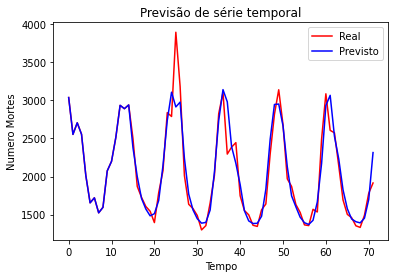

In [ ]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, lstm_predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Numero Mortes')
plt.legend()
#plt.savefig('lstm_predictions_training_test.svg')
plt.show()

#### Métricas de avaliação

In [ ]:
rmse = math.sqrt(mean_squared_error(test_pul, lstm_predicted))
print('RMSE: ', rmse)

RMSE:  191.69892002917732


In [ ]:
mape = np.mean(np.abs((test_pul - lstm_predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.563094162117826 %


In [ ]:
mse = mean_squared_error(test_pul, lstm_predicted)
print('MSE: ',mse)

MSE:  36748.475940352924


In [ ]:
mae = mean_absolute_error(test_pul, lstm_predicted)
print('MAE: ',mae)

MAE:  133.40599568684897


## Parte 3 - Construção da Rede GRU

#### Criar a estrutura de dados com janela 15 e output 1

In [ ]:
window = 15
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#### Reshaping

In [ ]:
X_train.shape

(45, 15)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(45, 15, 1)

#### Variáveis

In [ ]:
num_epoch = 500
learning_rate = 0.01
batch_size = 32

#### Callbacks

In [ ]:
#es = EarlyStopping(monitor="loss", min_delta = 0.00001, patience = 100, mode = 'min', restore_best_weights=True, verbose = True)
rlr = ReduceLROnPlateau(monitor='loss', patience=100, mode = 'min', factor=0.1, verbose = True)
#mc = ModelCheckpoint(filepath= 'best_GRU_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True, verbose = True)

#### Otimizadores

In [ ]:
adam = Adam(lr=learning_rate, decay=1e-7)
#sgd = SGD(lr=learning_rate, decay=1e-7, momentum=0.9, nesterov=False)

#### Construção da Rede LSTM

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
#regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))
# Second GRU layer
#regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=adam, loss='mean_squared_error', metrics = ['mean_absolute_error'])

#### Treinamento

In [ ]:
# Fitting to the training set
regressorGRU.fit(X_train, y_train, epochs = num_epoch, batch_size = batch_size, callbacks = [rlr]) 

Epoch 1/500
2/2 [==============================] - 3s 18ms/step - loss: 0.1230 - mean_absolute_error: 0.2612
Epoch 2/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0680 - mean_absolute_error: 0.2140
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0667 - mean_absolute_error: 0.1691
Epoch 4/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0403 - mean_absolute_error: 0.1657
Epoch 5/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0475 - mean_absolute_error: 0.1891
Epoch 6/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0365 - mean_absolute_error: 0.1565
Epoch 7/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0379 - mean_absolute_error: 0.1399
Epoch 8/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0298 - mean_absolute_error: 0.1353
Epoch 9/500
2/2 [==============================] - 0s 16ms/step - loss: 0.0248 - mean_absolute_error: 0.1292
Epoch 10/500
2/2 [=

### Fazer as previsões e analisar os resultados

#### Base de teste

In [ ]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

#### Construir a estrutura para teste

In [ ]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### Fazer as previsões

In [ ]:
GRU_predicted = regressorGRU.predict(X_test)
GRU_predicted = sc.inverse_transform(GRU_predicted)

#### Visualizar os resultados de treino e teste

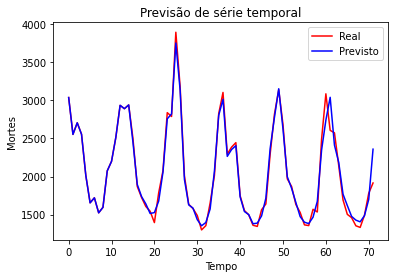

In [ ]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressorGRU.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, GRU_predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Mortes')
plt.legend()
plt.savefig('gru_predictions_training_test.svg')
plt.show()

#### Métricas

In [ ]:
rmse = math.sqrt(mean_squared_error(test_pul, GRU_predicted))
print('RMSE: ', rmse)

RMSE:  217.61153913228267


In [ ]:
mse = mean_squared_error(test_pul, GRU_predicted)
print('MSE: ',mse)

MSE:  47354.781963520996


In [ ]:
mape = np.mean(np.abs((test_pul - GRU_predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  7.364326950596284 %


In [ ]:
mae = mean_absolute_error(test_pul, GRU_predicted)
print('MAE: ',mae)

MAE:  155.59162394205728
